<a href="https://colab.research.google.com/github/amaziarczyk/Mniejsze_projekty/blob/master/Pozosta%C5%82e_projekty/Segmentacja_klient%C3%B3w.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Akcja segmentacja 





 
Celem jest wykorzystanie uczenia nienadzorowanego do wykonania segmentacji klientó
 
    * CustomerID - unikalny identyfikator klienta
    * Profit - jaką profitowość przynosi klient, wartość bez jednostki, im wyższa wartość tym lepiej
    * Recency - ile dni temu było ostatnie zamówienie klienta, ilość w dniach, im niższa wartość tym lepiej
    * Frequency	 - jak często klient zamawiał produkty, wartość bez jednostki, im wyższa wartość tym lepiej
    * Monetary	- całkowita wartość zamówionych produktów przez klienta, jednostka PLN, im wyższa wartość tym lepiej
    * Variance - ilość różnorodnych produktów, które zostały zamówione przez klienta, wartość bez jednostki, im wyższa wartość tym lepiej


##Roziwązanie zdania


In [ ]:
#import bibliotek
import pandas as pd
import numpy as np
import sklearn
import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
#Załadowanie i wyświetlenie pierwszych 5 wierszy ze zbioru danych. Konieczne jest użycie separatora między zmiennymi ";"
url='/content/drive/MyDrive/Asseco/Wyzwania Data Science_Machine Learning/Customers.csv'
df2=pd.read_csv(url, sep=";")
df2.head()

,CustomerId,Profit,Recency,Frequency,Monetary,Variance
0,1,187,63,1,"2349,06",2
1,2,96,10,6,"922,62",4
2,3,47,35,4,"881,22",3
3,4,294,5,1,"3815,16",2
4,5,732,4,31,"41868,11",29


In [ ]:
#praca na kopii danych i sprawdzenie podstawowych informacji
df=df2.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1511 entries, 0 to 1510
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   CustomerId  1511 non-null   int64 
 1   Profit      1511 non-null   int64 
 2   Recency     1511 non-null   int64 
 3   Frequency   1511 non-null   int64 
 4   Monetary    1511 non-null   object
 5   Variance    1511 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 71.0+ KB


###Przygotowanie danych do modelowania

In [ ]:
#konwersja zmiennej 'Monetary' z typu 'object' na 'float'
df['Monetary']=df['Monetary'].str.replace(",",".").astype('float')

####Normalizacja wartości

In [ ]:
#Normalizacja wartości. Sprowadzenie wartości do skali od 0 do 1. 
df_norm=(df-df.min())/(df.max()-df.min())

#sprawdzenie czy jest normalizacja z min 0 i max 1
df_norm.describe()

,CustomerId,Profit,Recency,Frequency,Monetary,Variance
count,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000
mean,0.500000,0.010391,0.164968,0.124489,0.005389,0.113573
std,0.288962,0.051491,0.211687,0.132677,0.055043,0.128292
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.000736,0.033333,0.025641,0.000043,0.028986
50%,0.500000,0.002104,0.055556,0.102564,0.000178,0.072464
75%,0.750000,0.005269,0.200000,0.173077,0.000685,0.159420
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


####Usunięcie wartości odstających

In [ ]:
#określenie wartości odstającyh "outliersów" przy pomocy LocalOutlierFactor dla klasyfikatora nienadzorowanego

from sklearn.neighbors import LocalOutlierFactor
lof=LocalOutlierFactor(n_neighbors=20)
y_pred=lof.fit_predict(df_norm)

#usunięcie wartości odstających ze zbioru i sprawdzenie jak zmieniła się liczba obserwacji
df_norm['y_pred']=y_pred
df_norm=df_norm[df_norm['y_pred']==1]

print(f'Jako wartości odstające zdefiniowano {df.shape[0]-df_norm.shape[0]} wartości')
print("")
print("")
print("---------------------")
df_norm.info()

Jako wartości odstające zdefiniowano 48 wartości


---------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1463 entries, 0 to 1510
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerId  1463 non-null   float64
 1   Profit      1463 non-null   float64
 2   Recency     1463 non-null   float64
 3   Frequency   1463 non-null   float64
 4   Monetary    1463 non-null   float64
 5   Variance    1463 non-null   float64
 6   y_pred      1463 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 91.4 KB


In [ ]:
#wybranie zmiennych do modelowania
df_norm2=df_norm.drop(columns=['CustomerId','y_pred'])
df_norm2.head(3)

,Profit,Recency,Frequency,Monetary,Variance
0,0.001755,0.688889,0.000000,0.000072,0.007246
1,0.000896,0.100000,0.064103,0.000028,0.021739
2,0.000434,0.377778,0.038462,0.000027,0.014493


### Model K-średnich

In [ ]:
from sklearn.cluster import KMeans

#funkacja do wybór ilości klastrów
wcss=[]
for i in range(2,10):
  kmeans=KMeans(n_clusters=i)
  kmeans.fit(df_norm2)
  wcss.append(kmeans.inertia_)

#DataFrame z danymi funkcji
df_wcss=pd.DataFrame(wcss, columns=['wcss'])
df_wcss=df_wcss.reset_index()
df_wcss=df_wcss.rename(columns={'index':'clusters'})
df_wcss['clusters']+=1
df_wcss.head()

,clusters,wcss
0,1,36.614314
1,2,23.550257
2,3,17.446631
3,4,14.275162
4,5,11.611290


In [ ]:
#wizualizacja i wykorzystanie regułu "łokcia", wykorzystanie ostaniego załamania jako liczba klastrów
px.line(df_wcss, x='clusters', y='wcss', height=300, width=500, color_discrete_sequence=['#51ace0'], template="plotly_white")

In [ ]:
#budowa modelu K-średnich
kmeans=KMeans(n_clusters=3)
kmeans.fit(df_norm2)
SegmentId=kmeans.predict(df_norm2)

#dodanie zmiennej z numerem klastra
df_norm2['SegmentId']=SegmentId
df_norm2.head()

,Profit,Recency,Frequency,Monetary,Variance,SegmentId
0,0.001755,0.688889,0.000000,0.000072,0.007246,1
1,0.000896,0.100000,0.064103,0.000028,0.021739,0
2,0.000434,0.377778,0.038462,0.000027,0.014493,1
3,0.002764,0.044444,0.000000,0.000117,0.007246,0
4,0.006897,0.033333,0.384615,0.001286,0.202899,2


In [ ]:
#predykcja na podstawie modelu dla wszystkich zmiennych
SegmentId_2=kmeans.predict(df.drop(columns=['CustomerId'], axis=1))
df['SegmentId']=SegmentId_2
df.head(3)

,CustomerId,Profit,Recency,Frequency,Monetary,Variance,SegmentId
0,1,187,63,1,2349.06,2,1
1,2,96,10,6,922.62,4,1
2,3,47,35,4,881.22,3,1


#### Redukcja ilości zmiennych- PCA

In [ ]:
!pip install factor_analyzer

     |████████████████████████████████| 40kB 5.6MB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.3.2-cp37-none-any.whl size=40398 sha256=ea194e3177954b3c366bd9a4ccbb54931698b6abb201c69de0f59253aa43a2b4
  Stored in directory: /root/.cache/pip/wheels/4a/d0/57/f1330cb9c80e82d8d05391c74c94ed61ce3f03bf6157f3d6db
Successfully built factor-analyzer


In [ ]:
# sprawdzenie czy redukcja wymiarów jest porządana dla danych, 
#wykorzystanie testu Kaisera-Meyera-Olkina(KMO).KMO szacuje proporcję wariancji wśród wszystkich zmiennych. Wartości KMO mieszczą się od 0 do 1. KMO<0,6 jest uważana za niewystarczającą. 
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all,kmo_model=calculate_kmo(df_norm2)
kmo_model
 
#interpretacja otrzymanego wyniku
if kmo_model >0.6:
  print(f'Wartość testu KMO wynosi: {kmo_model.round(2)} czyli jest >0.6. Oznacza to że warto redukować wymiar zmiennych')
else:
  print(f'Wartość testu KMO wynosi: {kmo_model.round(2)} czyli jest <0.6. Oznacza to że nie warto redukować wymiaru zmiennych')
print('') 

Wartość testu KMO wynosi: 0.63 czyli jest >0.6. Oznacza to że warto redukować wymiar zmiennych



/usr/local/lib/python3.7/dist-packages/factor_analyzer/utils.py:248: UserWarning:

The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.



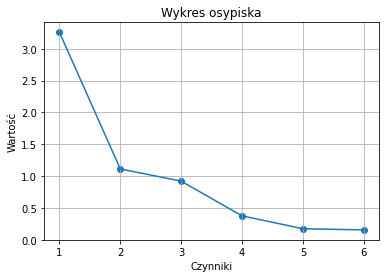

In [ ]:
#wybór ilości zmiennych
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(rotation=None)
fa.fit(df_norm2)

#sprawdzenie kryterium Keisera 
ev, v = fa.get_eigenvalues()

#wykres osypiska. Ilość wartości większych  od 1 uważane za ilość zmiennych
plt.scatter(range(1,df_norm2.shape[1]+1),ev)
plt.plot(range(1,df_norm2.shape[1]+1),ev)
plt.title('Wykres osypiska')
plt.xlabel('Czynniki')
plt.ylabel('Wartość')
plt.grid()
plt.show()

In [ ]:
#budowa modelu redukującego liczbę zmiennych- PCA
from sklearn.decomposition import PCA

pca=PCA(n_components=3)
df_p=pca.fit_transform(df_norm2)

df_pca=pd.DataFrame(df_p, columns=['Conponent_1', 'Conponent_2','Conponent_3'])
df_pca['SegmentId']=df_norm2['SegmentId']
df_pca.head(3)

,Conponent_1,Conponent_2,Conponent_3,SegmentId
0,0.179865,0.547307,0.008764,1.0
1,-0.809482,-0.061252,-0.035494,0.0
2,0.183209,0.241609,-0.060333,1.0


In [ ]:
pca.explained_variance_ratio_

array([0.93117134, 0.05986564, 0.00487859])

####Wizualizacja grup klientów

In [ ]:
#wizualizacja skupień klientów na
px.scatter_3d(df_pca,x='Conponent_1', y='Conponent_2',z="Conponent_3", width=1200, height=500)
                                                                   

Klienci zostali pogrupowani na trzy skupienia według algorytmu KMeans. W dalszym kroku można sprawdzi, które zmienne definiują najlepiej zmienną.

### Zapis

In [ ]:
#zapis pliku
df.to_csv('Customers.csv')

## Zadanie dodatkowe

In [ ]:
df_rfm=df2.copy()
df_rfm.head()

,CustomerId,Profit,Recency,Frequency,Monetary,Variance
0,1,187,63,1,"2349,06",2
1,2,96,10,6,"922,62",4
2,3,47,35,4,"881,22",3
3,4,294,5,1,"3815,16",2
4,5,732,4,31,"41868,11",29


In [ ]:
#podział według skali RFM 1-5

  #Recency im niższa wartość tym lepiej
df_rfm['recency_rfm']=pd.cut(df_rfm['Recency'], bins=5, labels=[5,4,3,2,1])
  #Frequency im wyższa wartość tym lepiej
df_rfm['frequency_rfm']=pd.cut(df_rfm['Frequency'], bins=5, labels=[1,2,3,4,5])
  #Monetary im wyższa wartość tym lepiej
df_rfm['monetary_rfm']=pd.cut(df_rfm['Monetary'].str.replace(",",".").astype('float'), bins=5, labels=[1,2,3,4,5])
df_rfm.head(10)

,CustomerId,Profit,Recency,Frequency,Monetary,Variance,recency_rfm,frequency_rfm,monetary_rfm
0,1,187,63,1,"2349,06",2,2,1,1
1,2,96,10,6,"922,62",4,5,1,1
2,3,47,35,4,"881,22",3,4,1,1
3,4,294,5,1,"3815,16",2,5,1,1
4,5,732,4,31,"41868,11",29,5,2,1
5,6,37,16,3,"2053,4",8,5,1,1
6,7,264,11,12,"4861,49",12,5,1,1
7,8,188,4,8,"4010,69",9,5,1,1
8,9,316,4,21,"12636,8",20,5,2,1
9,10,528,5,18,"17741,24",26,5,2,1


In [ ]:
#pobranie tabeli z charakterystyką klentów
df_opis=pd.read_html('https://rfm.rsquaredacademy.com/articles/rfm-customer-level-data.html#segments')
df_opis=df_opis[1]
df_opis

,Segment,Description,R,F,M
0,Champions,"Bought recently, buy often and spend the most",4 - 5,4 - 5,4 - 5
1,Loyal Customers,Spend good money. Responsive to promotions,2 - 5,3 - 5,3 - 5
2,Potential Loyalist,"Recent customers, spent good amount, bought mo...",3 - 5,1 - 3,1 - 3
3,New Customers,"Bought more recently, but not often",4 - 5,<= 1,<= 1
4,Promising,"Recent shoppers, but haven’t spent much",3 - 4,<= 1,<= 1
5,Need Attention,"Above average recency, frequency & monetary va...",2 - 3,2 - 3,2 - 3
6,About To Sleep,"Below average recency, frequency & monetary va...",2 - 3,<= 2,<= 2
7,At Risk,"Spent big money, purchased often but long time...",<= 2,2 - 5,2 - 5
8,Can’t Lose Them,"Made big purchases and often, but long time ago",<= 1,4 - 5,4 - 5
9,Hibernating,"Low spenders, low frequency, purchased long ti...",1 - 2,1 - 2,1 - 2


In [ ]:
df_opis['M'].tolist()

['4 - 5',
 '3 - 5',
 '1 - 3',
 '<= 1',
 '<= 1',
 '2 - 3',
 '<= 2',
 '2 - 5',
 '4 - 5',
 '1 - 2',
 '<= 2']

In [ ]:
df_opis['R_p']=[[4,5], [2,5], [3,5], [4,5], [3,4], [2,3], [2,3], [1,2], [1,1], [1,2], [1,2]]
df_opis['R_f']=[[4,5], [3,5], [1,3], [1,1], [1,1], [2,3], [1,2], [2,5], [4,5], [1,2], [1,2]]
df_opis['R_m']=[[4,5], [3,5], [1,3], [1,1], [1,1], [2,3], [1,2], [2,5], [4,5], [1,2], [1,2]]
df_opis

,Segment,Description,R,F,M,R_p,R_f,R_m
0,Champions,"Bought recently, buy often and spend the most",4 - 5,4 - 5,4 - 5,"[4, 5]","[4, 5]","[4, 5]"
1,Loyal Customers,Spend good money. Responsive to promotions,2 - 5,3 - 5,3 - 5,"[2, 5]","[3, 5]","[3, 5]"
2,Potential Loyalist,"Recent customers, spent good amount, bought mo...",3 - 5,1 - 3,1 - 3,"[3, 5]","[1, 3]","[1, 3]"
3,New Customers,"Bought more recently, but not often",4 - 5,<= 1,<= 1,"[4, 5]","[1, 1]","[1, 1]"
4,Promising,"Recent shoppers, but haven’t spent much",3 - 4,<= 1,<= 1,"[3, 4]","[1, 1]","[1, 1]"
5,Need Attention,"Above average recency, frequency & monetary va...",2 - 3,2 - 3,2 - 3,"[2, 3]","[2, 3]","[2, 3]"
6,About To Sleep,"Below average recency, frequency & monetary va...",2 - 3,<= 2,<= 2,"[2, 3]","[1, 2]","[1, 2]"
7,At Risk,"Spent big money, purchased often but long time...",<= 2,2 - 5,2 - 5,"[1, 2]","[2, 5]","[2, 5]"
8,Can’t Lose Them,"Made big purchases and often, but long time ago",<= 1,4 - 5,4 - 5,"[1, 1]","[4, 5]","[4, 5]"
9,Hibernating,"Low spenders, low frequency, purchased long ti...",1 - 2,1 - 2,1 - 2,"[1, 2]","[1, 2]","[1, 2]"
